# Experient imputation methods with AIF360

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"
import sys
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.completer import complete_by_mean_col, complete_by_mean_col_v2
from utils.completer import complete_by_multi, complete_by_multi_v2
from utils.completer import complete_by_similar_row, complete_by_similar_row_v2
from utils.generator import gen_complete_random
from utils.data import create_adult_dataset

### Learning Fair Representations (LFR)
[example notebook](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_lfr.ipynb)  

------

The idea is to first apply imputation on original dataset (adult dataset here)  
Then feed the converted dataset into LFR to see any difference  

------

Note:  
In order to LFR to work on Python3.8  
Should install LFR directly from github, instead of from pip  

In [2]:
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.lfr import LFR

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [4]:
data = create_adult_dataset()
print(data.X.shape)
print(data.X.isnull().sum().sum())

(32561, 10)
0


In [5]:
data_incomplete = gen_complete_random(data, random_ratio=0.2)
print(data_incomplete.X.isnull().sum())

gen_complete_random: 58244 NaN values have been inserted
age               6520
workclass         6460
education         6405
education-num     6499
marital-status    6423
occupation        6490
relationship      6468
race              6454
hours-per-week    6525
sex                  0
dtype: int64


In [6]:
data_complete = complete_by_mean_col(data_incomplete)
print(data_complete.X.isnull().sum())

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
hours-per-week    0
sex               0
dtype: int64


In [7]:
data_complete.y_encoder.classes_

array([' <=50K', ' >50K'], dtype=object)

In [8]:
data_complete.categorical_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race']

In [9]:
data_complete.protected_features

['sex']

In [10]:
# convert to standard dataset
from sklearn.model_selection import train_test_split
tmp_df = pd.concat([data_complete.X, pd.DataFrame(data_complete.y, columns=["_TARGET_"])], axis=1).copy()
tmp_df['sex'] = tmp_df['sex'].apply(lambda x : 0.0 if x == ' Female' else 1.0) # necessary for aif360 to understand
tmp_df_train, tmp_df_test = train_test_split(tmp_df, test_size=0.3, shuffle=True)
data_imputed_train = StandardDataset(df=tmp_df_train, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                     protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                     features_to_keep=data_complete.X.columns.tolist(),
                                     instance_weights_name=None, features_to_drop=[],
                                     custom_preprocessing=None, categorical_features=data_complete.categorical_features)
data_imputed_test = StandardDataset(df=tmp_df_test, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                    protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                    features_to_keep=data_complete.X.columns.tolist(),
                                    instance_weights_name=None, features_to_drop=[],
                                    custom_preprocessing=None, categorical_features=data_complete.categorical_features)
print(tmp_df_train.shape)
print(tmp_df_test.shape)

(22792, 11)
(9769, 11)


In [11]:
privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]
metric_imputed_train = BinaryLabelDatasetMetric(data_imputed_train, 
                                                unprivileged_groups=unprivileged_groups,
                                                privileged_groups=privileged_groups)
metric_imputed_test = BinaryLabelDatasetMetric(data_imputed_test, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
print(metric_imputed_train.mean_difference())
print(metric_imputed_test.mean_difference())

-0.19687256847183315
-0.19488394242534504


In [12]:
scaler = StandardScaler()
data_imputed_train.features = scaler.fit_transform(data_imputed_train.features)
data_imputed_test.features = scaler.transform(data_imputed_test.features)

In [13]:
TR = LFR(unprivileged_groups=[{'sex': 0}],
         privileged_groups=[{'sex': 1}],
         k=10, Ax=0.01, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(data_imputed_train, maxiter=5000, maxfun=5000)

step: 0, loss: 0.6783762940135664, L_x: 2.561641631233007,  L_y: 0.6402576386903901,  L_z: 0.006251119505423093
step: 250, loss: 0.6783763146668952, L_x: 2.5616416718723967,  L_y: 0.6402576548998364,  L_z: 0.006251121524167376
step: 500, loss: 0.6783763126867599, L_x: 2.561641674050902,  L_y: 0.6402576442479718,  L_z: 0.006251125849139517
step: 750, loss: 0.6258931193051109, L_x: 2.5612446866608787,  L_y: 0.5882539803699335,  L_z: 0.006013346034284347
step: 1000, loss: 0.625893137567868, L_x: 2.5612447055337504,  L_y: 0.5882539950438782,  L_z: 0.006013347734326176
step: 1250, loss: 0.6258931432161025, L_x: 2.5612447009951875,  L_y: 0.5882540044914034,  L_z: 0.00601334585737356
step: 1500, loss: 0.592876108387816, L_x: 2.5602556423062874,  L_y: 0.5572239354251898,  L_z: 0.005024808269781693
step: 1750, loss: 0.5928761106585492, L_x: 2.5602556458270636,  L_y: 0.5572239363060097,  L_z: 0.005024808947134393
step: 2000, loss: 0.5900834836859262, L_x: 2.560053792147637,  L_y: 0.5552972012633

In [20]:
data_imputed_transf_train = TR.transform(data_imputed_train, threshold=0.3)
data_imputed_transf_test = TR.transform(data_imputed_test, threshold=0.3)
print(classification_report(data_imputed_test.labels, data_imputed_transf_test.labels, zero_division=0))
metric_imputed_transf_train = BinaryLabelDatasetMetric(data_imputed_transf_train, 
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
metric_imputed_transf_test = BinaryLabelDatasetMetric(data_imputed_transf_test, 
                                                      unprivileged_groups=unprivileged_groups,
                                                      privileged_groups=privileged_groups)
print(metric_imputed_transf_train.mean_difference())
print(metric_imputed_transf_test.mean_difference())

              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87      7417
         1.0       0.61      0.24      0.34      2352

    accuracy                           0.78      9769
   macro avg       0.70      0.59      0.60      9769
weighted avg       0.75      0.78      0.74      9769

-0.06465190242763773
-0.05894260817567394


In [15]:
def draw(dataset_orig_test, dataset_transf_test):
    from collections import OrderedDict
    from aif360.metrics import ClassificationMetric

    def compute_metrics(dataset_true, dataset_pred, 
                        unprivileged_groups, privileged_groups,
                        disp = True):
        """ Compute the key metrics """
        classified_metric_pred = ClassificationMetric(dataset_true,
                                                     dataset_pred, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        metrics = OrderedDict()
        metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                                 classified_metric_pred.true_negative_rate())
        metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
        metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
        metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
        metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
        metrics["Theil index"] = classified_metric_pred.theil_index()
    
        if disp:
            for k in metrics:
                print("%s = %.4f" % (k, metrics[k]))
    
        return metrics
    bal_acc_arr_transf = []
    disp_imp_arr_transf = []

    class_thresh_arr = np.linspace(0.01, 0.99, 100)

    dataset_transf_test_new = dataset_orig_test.copy(deepcopy=True)
    dataset_transf_test_new.scores = dataset_transf_test.scores

    for thresh in class_thresh_arr:
        fav_inds = dataset_transf_test_new.scores > thresh
        dataset_transf_test_new.labels[fav_inds] = 1.0
        dataset_transf_test_new.labels[~fav_inds] = 0.0
    
        metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_new, 
                                          unprivileged_groups, privileged_groups,
                                          disp = False)

        bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
        disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(class_thresh_arr, bal_acc_arr_transf)
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)

    ax2 = ax1.twinx()
    ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
    ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    plt.show()

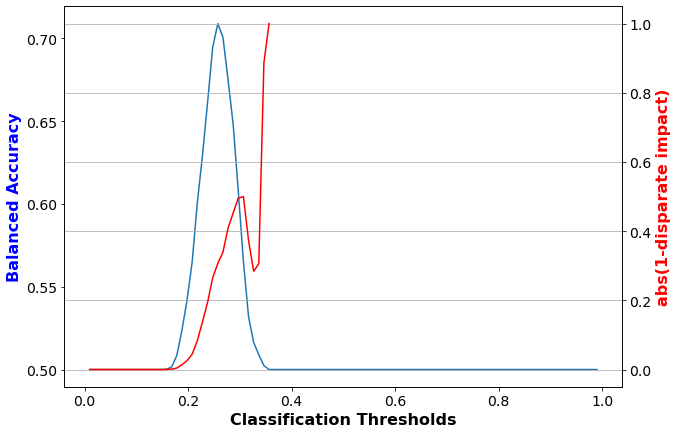

In [16]:
draw(data_imputed_test, data_imputed_transf_test)

In [21]:
# compare with original dataset
tmp_df = pd.concat([data.X, pd.DataFrame(data.y, columns=["_TARGET_"])], axis=1).copy()
tmp_df['sex'] = tmp_df['sex'].apply(lambda x : 0.0 if x == ' Female' else 1.0) # necessary for aif360 to understand
tmp_df_train, tmp_df_test = train_test_split(tmp_df, test_size=0.3, shuffle=True)
data_train = StandardDataset(df=tmp_df_train, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                             protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                             features_to_keep=data_complete.X.columns.tolist(),
                             instance_weights_name=None, features_to_drop=[],
                             custom_preprocessing=None, categorical_features=data_complete.categorical_features)
data_test = StandardDataset(df=tmp_df_test, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                            protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                            features_to_keep=data_complete.X.columns.tolist(),
                            instance_weights_name=None, features_to_drop=[],
                            custom_preprocessing=None, categorical_features=data_complete.categorical_features)
print(tmp_df_train.shape)
print(tmp_df_test.shape)
metric_train = BinaryLabelDatasetMetric(data_train, 
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
metric_test = BinaryLabelDatasetMetric(data_test, 
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
print(metric_train.mean_difference())
print(metric_test.mean_difference())

(22792, 11)
(9769, 11)
-0.19431354978052562
-0.20095601486424686


In [22]:
data_train.features = scaler.fit_transform(data_train.features)
data_test.features = scaler.transform(data_test.features)
TR = LFR(unprivileged_groups=[{'sex': 0}],
         privileged_groups=[{'sex': 1}],
         k=10, Ax=0.01, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(data_train, maxiter=5000, maxfun=5000)

step: 0, loss: 0.8571666920002743, L_x: 2.5574058778864837,  L_y: 0.8120057981637012,  L_z: 0.009793417528854109
step: 250, loss: 0.857166676738537, L_x: 2.5574058939982782,  L_y: 0.812005784204882,  L_z: 0.009793416796836082
step: 500, loss: 0.8571667129156907, L_x: 2.557405912724297,  L_y: 0.8120057987514178,  L_z: 0.009793427518514999
step: 750, loss: 0.682617690220423, L_x: 2.557266799639108,  L_y: 0.6379638027371836,  L_z: 0.009540609743424116
step: 1000, loss: 0.6826176984413685, L_x: 2.5572667889462917,  L_y: 0.6379638125989652,  L_z: 0.009540608976470251
step: 1250, loss: 0.6826176814658526, L_x: 2.5572668045939624,  L_y: 0.6379637885760692,  L_z: 0.009540612421921885
step: 1500, loss: 0.5906637764679055, L_x: 2.55674943163858,  L_y: 0.5475991732252457,  L_z: 0.008748554463136975
step: 1750, loss: 0.5906637697847922, L_x: 2.5567494512152384,  L_y: 0.5475991666885682,  L_z: 0.008748554292035823
step: 2000, loss: 0.586984953283679, L_x: 2.5565685767443442,  L_y: 0.544761222143201

In [26]:
data_transf_train = TR.transform(data_train, threshold=0.3)
data_transf_test = TR.transform(data_test, threshold=0.3)
print(classification_report(data_test.labels, data_transf_test.labels, zero_division=0))
metric_transf_train = BinaryLabelDatasetMetric(data_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
metric_transf_test = BinaryLabelDatasetMetric(data_transf_test, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)
print(metric_transf_train.mean_difference())
print(metric_transf_test.mean_difference())

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      7383
         1.0       0.50      0.00      0.00      2386

    accuracy                           0.76      9769
   macro avg       0.63      0.50      0.43      9769
weighted avg       0.69      0.76      0.65      9769

-0.0005227049983665469
-0.00030840400925212025


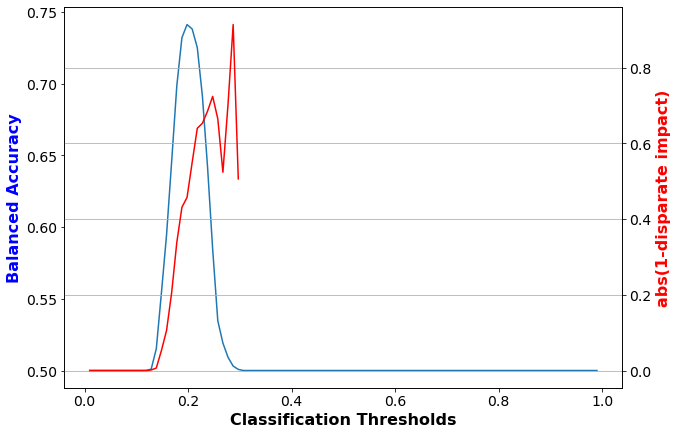

In [27]:
draw(data_test, data_transf_test)

In [28]:
# compare consistency
print("Consistency of labels in imputed transformed training dataset= %f" %metric_imputed_transf_train.consistency())
print("Consistency of labels in imputed training dataset= %f" %metric_imputed_train.consistency())
print("Consistency of labels in imputed transformed test dataset= %f" %metric_imputed_transf_test.consistency())
print("Consistency of labels in imputed test dataset= %f" %metric_imputed_test.consistency())

Consistency of labels in imputed transformed training dataset= 0.985697
Consistency of labels in imputed training dataset= 0.806888
Consistency of labels in imputed transformed test dataset= 0.979425
Consistency of labels in imputed test dataset= 0.798035


In [29]:
print("Consistency of labels in transformed training dataset= %f" %metric_transf_train.consistency())
print("Consistency of labels in original training dataset= %f" %metric_train.consistency())
print("Consistency of labels in transformed test dataset= %f" %metric_transf_test.consistency())
print("Consistency of labels in original test dataset= %f" %metric_test.consistency())

Consistency of labels in transformed training dataset= 0.999649
Consistency of labels in original training dataset= 0.822420
Consistency of labels in transformed test dataset= 0.999713
Consistency of labels in original test dataset= 0.820023
